# Example 4: Gibbs sampling for original posterior 

In [38]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

6


In [39]:
# Import module. 
using Revise
using PriorNormalization

In [40]:
# Import packages 
using ApproxFun # for approximating gammainvccdf by a Chbychev interpolant
using CairoMakie # for plots 
using Dates # to measure computational time 
using JLD2 # for saving and loading results
using FFTW # for discrete cosine transform
using FlexiMaps # for log-range 
using ImagePhantoms # for CT image 
using LinearAlgebra # to represent the identity matrix as "I" 
using MIRTjim: jim, prompt # for plotting image
using Printf # for specific output format 
using RadonKA # for Radon transform 
using Random # for generating random noise 
using Statistics  # for mean and quantile
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SparseArrays # for efficient storing of the forward operator 
using SpecialFunctions
using Trixi # for setting up the semi-discretization
using Turing # for setting up the model and sampling 
using Optim # for ML and MAP estimation 
using OrdinaryDiffEq # for time integration
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 

## Define the data model 

In [41]:
# Select the model i=1,2,3,4 for r=1,1/2,-1/2,-1
model_nr = 4

# Sampler parameters 
nr_chains = 4 # number of MCMC chains 
nr_samples_raw = 10^5 # Number of samples
thin = 10^2 # Thinning factor 
init = "prior" # Initialization option: "MAP", "prior"

"prior"

In [42]:
# Problem parameters 
n = 20 # number of pixes in each direction 
σ² = 1e-2 # noise variance  
Random.seed!(123) # Setting the random seed 
N = n^2

400

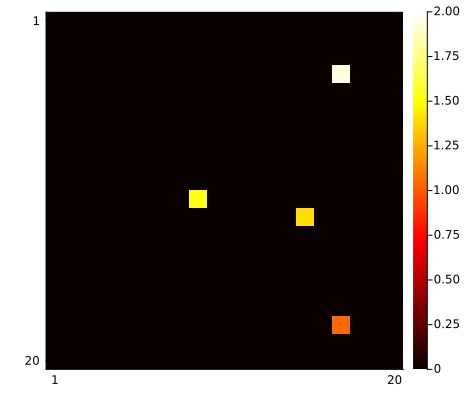

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_imageRef.pdf"

In [43]:
# Fill image with zeros 
image_ref = shepp_logan(n) 
image_ref .= 0

# Fill 5% of the entries with random numbers between 0 and 1 
nr_support = Int64(ceil( (n^2)*1/100 )) 
coord_support = rand(CartesianIndices(image_ref), nr_support)
values_support = rand(Float64, nr_support) .+ 1
image_ref[coord_support] = values_support

p = jim(image_ref, color=:hot, clim=(0,2), size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "impulse_n$(n)_imageRef.pdf"
)
#savefig(output_filename)

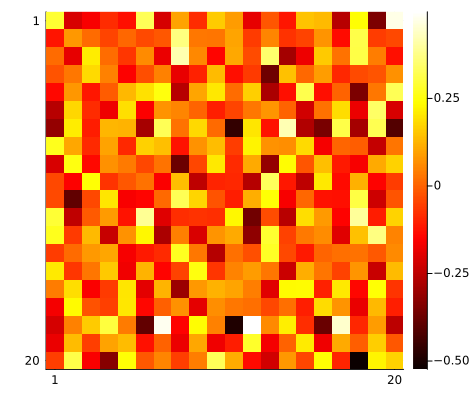

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_obsData.pdf"

In [44]:
image_obs = FFTW.dct(image_ref) + sqrt(σ²).*randn(size(image_ref))
p = jim(image_obs, color=:hot, size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "impulse_n$(n)_obsData.pdf"
)
#savefig(output_filename)

## Select the model: $r=-1$

In [45]:
# Select hyper-hyper-parameters 
model_nr = 4 

# Parameter of of generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

0.00012308

### Load and transform the samples

In [46]:
# Select the file names for loading the MCMC results 
    
# Use MAP estimate 
if init=="MAP"
    filename_original = joinpath("data", 
        "impulse_n$(n)_model$(model_nr)_mcmc_initMAP_Gibbs_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

elseif init=="prior"
    filename_original = joinpath("data", 
        "impulse_n$(n)_model$(model_nr)_mcmc_initPrior_Gibbs_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )

else
    error("Invalid initialization option provided: $init. Please choose either 'MAP' or 'prior'.")
end
    
@load filename_original chn_original wall_duration_original

2-element Vector{Symbol}:
 :chn_original
 :wall_duration_original

## Load statistics

In [47]:
filename = joinpath(
        "data/impulse_n$(n)_model$(model_nr)_statistics_$(init)_Gibbs_original_samples$(nr_samples_raw)_thin$(thin)_chains$(nr_chains).jld2"
    )
@load filename x_mean_original x_std_original x_var_original x_upper_quantile_original theta_mean_original theta_std_original theta_var_original theta_upper_quantile_original

# Rename 
θ_mean_original = theta_mean_original
θ_std_original = theta_std_original
θ_var_original = theta_var_original
θ_upper_quantile_original = theta_upper_quantile_original

400-element Vector{Float64}:
 0.0019721970428442544
 0.0019267050869563927
 0.00197760016043356
 0.001998551060351013
 0.0020815778157799053
 0.0018522714637802516
 0.0017544816268525464
 0.001988105933525051
 0.0017666303631850536
 0.002159000497502085
 ⋮
 0.0018331952100504839
 0.0021052093446282407
 0.002023112276470815
 0.0016905663989926498
 0.002003447247535167
 0.0017296360044897964
 0.0018866701999887383
 0.0019391095821053137
 0.0019597750439992673

## Illustrate UQ for the original posterior

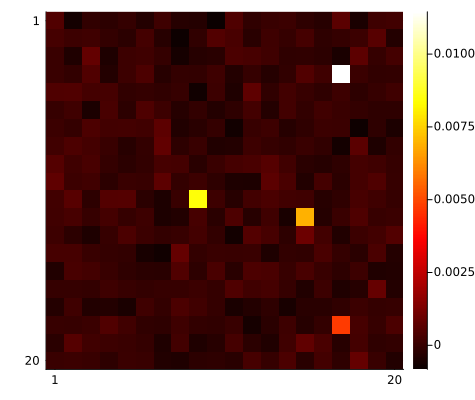

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_x_mean_Gibbs_original.pdf"

In [48]:
# Plot mean for x 
image = reshape( x_mean_original, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Mean of x", size = (475,400)) 
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_x_mean_Gibbs_original.pdf"
)
#savefig(output_filename)

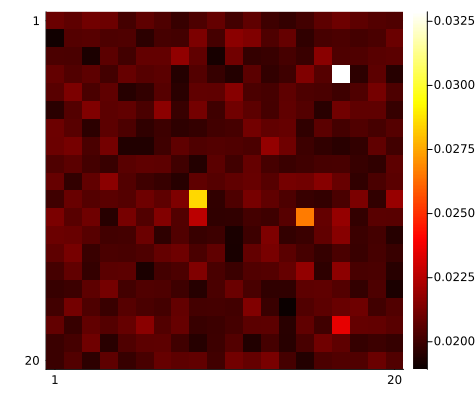

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_x_std_Gibbs_original.pdf"

In [49]:
# Plot standard deviation for x 
image = reshape( x_std_original, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Std. of x", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_x_std_Gibbs_original.pdf"
)
#savefig(output_filename)

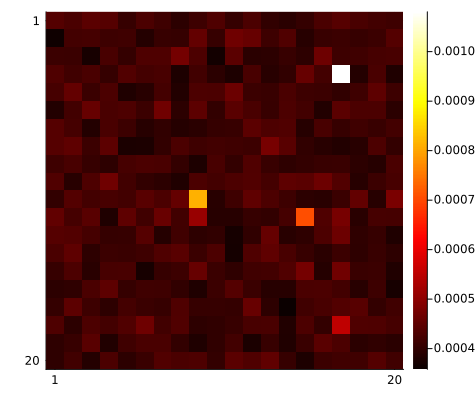

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_x_var_Gibbs_original.pdf"

In [50]:
# Plot variance for x 
image = reshape( x_var_original, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Variance of x", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_x_var_Gibbs_original.pdf"
)
#savefig(output_filename)

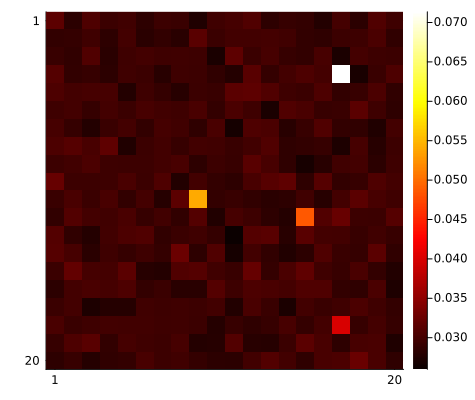

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_x_quantile_Gibbs_original.pdf"

In [51]:
# Plot upper quantile for x 
image = reshape( x_upper_quantile_original, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="95% quantile of x", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_x_quantile_Gibbs_original.pdf"
)
#savefig(output_filename)

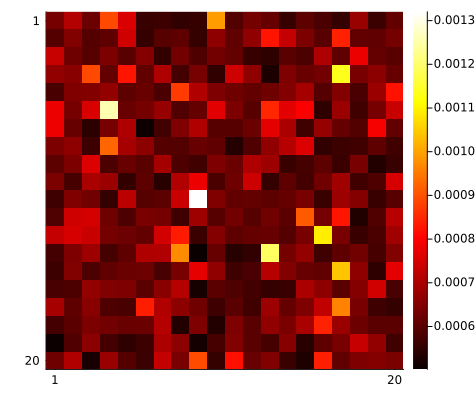

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_theta_mean_Gibbs_original.pdf"

In [52]:
# Plot mean for θ 
image = reshape( θ_mean_original, n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Mean of θ", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_theta_mean_Gibbs_original.pdf"
)
#savefig(output_filename)

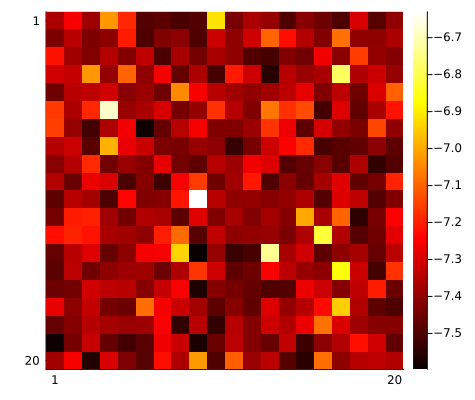

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/impulse_n20_model4_theta_logMean_Gibbs_original.pdf"

In [53]:
# Plot mean for θ 
image = reshape( log.(θ_mean_original), n, n )
p = jim(image, color=:hot, size = (475,400)) 
#p = jim(image, color=:hot, title="Mean of θ", size = (475,400))
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures",
    "impulse_n$(n)_model$(model_nr)_theta_logMean_Gibbs_original.pdf"
)
#savefig(output_filename)